# マイナビ × SIGNATE Student Cup 2019: 賃貸物件の家賃予測 (SIGNATE 練習問題用コンペティション)

#### 【課題】
不動産業界には、自動化、効率化、客観化の余地がまだまだたくさんあります。例えば、不動産の物件価格推定などです。<br>
物件価格は公示地価や路線価などをベースに算定されていますが、他の要因もあるため、人の経験や勘に依るところが多いです。<br>
そのため、価格を決定するのに時間がかかったり、人によってばらつきが生じたり、妥当な価格になっていない場合があります。<br>
AIが妥当で客観的な物件価格を算出してくれれば、大きな作業効率化につながります。<br>
今回は不動産業界でのAI活用の一例として、賃貸物件の家賃推定に取り組みます。<br>

#### 【本コンペについて】
このコンペティションは『所在地や間取り、築年数などのデータから、東京23区における賃貸物件の家賃を予測するモデルを作成する』という内容の練習課題です。<br>
コンペティション内では物件に関するデータ 「train.csv」「test.csv」が配布されています。<br>
train.csvの物件データを用いてモデルを作成し、モデルを用いてtest.csvのデータから物件の家賃（賃料）を予測する『回帰問題』になります。<br>

※配布データの再配布は禁止

#### 【データ概要】
#### 学習用：物件の賃料と住所等を記したデータ（目的変数：賃料、説明変数：物件の面積や間取り、階数など、データ数：31,470）
#### テスト用：物件の住所等を記したデータ（データ数：31,262）

### 

##### １．物件データの読み込み・整形
##### ２．賃料に影響のある要素を探索　
##### ３．賃料予測モデルの作成
##### ４．テストデータによる予測

### 

## １．物件データの読み込み・整形

まずは今回のデータ分析に使用するライブラリをimportします。それぞれ以下の機能が提供されています。

numpy：数値計算、pandas：データ加工、re：正規表現操作、matplotlib＆seaborn：グラフによる可視化、scikit-learn：機械学習モデルの提供、PIL（Pillow）：画像処理

In [1]:
# numpy, pandas, matplotlib, seabornライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 正規表現操作
import re
# 日本語フォント設定
from matplotlib.font_manager import FontProperties
# scikit-learnライブラリ(データ分割、回帰ランダムフォレスト、MSE:評価指標)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
# 画像処理
from PIL import Image

In [2]:
# MSゴシックを設定(グラフ作成において日本語表記が可能になる)
fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size=12)

In [3]:
# 実行時の警告を非表示
import warnings
warnings.filterwarnings('ignore')

学習データ「train.csv」を読み込みます。train.csvの内容は以下の通りです。<br>
<br>
【カラム一覧】<br>
id：物件ID <br>
賃料：賃料（目的変数） <br>
所在地：住所 <br>
アクセス：最寄りの路線等 <br>
間取り：間取り <br>
築年数：築年数 <br>
方角：方角 <br>
面積：面積<br>
所在階：物件自体の階数と物件がある建物の総階数 <br>
バス・トイレ：バス・トイレの建てつけ等 <br>
キッチン：キッチンの建てつけ等 <br>
放送・通信：通信設備の建てつけ等 <br>
室内設備：室内設備の建てつけ等 <br>
駐車場：駐車場の有無等 <br>
周辺環境：最寄りのスーパー等 <br>
建築構造：建築構造 <br>
契約期間：契約期間 (2019年8月が起点となります) <br>

In [4]:
# 学習データの読み込み
data = pd.read_csv('./signate_data/rental/train.csv')
# 学習データを表示
data

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31465,31466,80000,東京都板橋区蓮根２丁目,都営三田線\t蓮根駅\t徒歩7分\t\t都営三田線\t西台駅\t徒歩10分\t\t都営三田線...,2DK,30年0ヶ月,南,37.9m2,1階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ2口／\t給湯,インターネット対応,エアコン付\tバルコニー／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,鉄骨造,2年間
31466,31467,54500,東京都世田谷区太子堂５丁目17-1,東急田園都市線\t三軒茶屋駅\t徒歩6分\t\t東急世田谷線\t西太子堂駅\t徒歩4分\t\...,1R,39年7ヶ月,西,12.04m2,4階／4階建,専用バス／\t専用トイレ／\tシャワー,ガスコンロ／\tコンロ1口／\t給湯,NaN,エアコン付\tバルコニー／\tフローリング／\t室外洗濯機置場／\tタイル張り\t公営水道／...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 458m\t【スーパー】 540m\t【コンビニ】 131m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
31467,31468,125000,東京都江東区南砂４丁目,東西線\t南砂町駅\t徒歩5分\t\t都営新宿線\t大島(東京都)駅\t徒歩26分\t\t東...,3DK,45年10ヶ月,南,60m2,3階／5階建,バス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座,ガスコンロ／\tコンロ2口,光ファイバー,シューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場\t都市ガス,駐輪場\t空有\tバイク置き場\t無,【コンビニ】 302m\t【コンビニ】 394m\t【コンビニ】 452m\t【コンビニ】 ...,鉄骨造,2年間
31468,31469,98000,東京都中野区中野２丁目,中央線（快速）\t中野(東京都)駅\t徒歩4分\t\t丸ノ内線(池袋－荻窪)\t新中野駅\t...,1DK,11年0ヶ月,南,29.59m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t3面採光／\t室内洗濯...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 485m\t【スーパー】 1051m\t【コンビニ】 476m\t【コンビニ】...,木造,2年間


In [5]:
# 学習データの情報を確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31470 entries, 0 to 31469
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31470 non-null  int64 
 1   賃料      31470 non-null  int64 
 2   所在地     31470 non-null  object
 3   アクセス    31470 non-null  object
 4   間取り     31470 non-null  object
 5   築年数     31470 non-null  object
 6   方角      28721 non-null  object
 7   面積      31470 non-null  object
 8   所在階     31470 non-null  object
 9   バス・トイレ  31141 non-null  object
 10  キッチン    30849 non-null  object
 11  放送・通信   28030 non-null  object
 12  室内設備    31388 non-null  object
 13  駐車場     26183 non-null  object
 14  周辺環境    22038 non-null  object
 15  建物構造    31470 non-null  object
 16  契約期間    24350 non-null  object
dtypes: int64(2), object(15)
memory usage: 4.1+ MB


ここで「面積」カラムを確認すると、m2という面積の単位がデータに含まれています。<br>
このままでは量的データとして扱うことができないので、float型の数値に変換する関数を作成し、このカラムに対して実行させましょう。<br>

In [6]:
# 後ろ2文字を削除、float型に変換する関数change_area()を作成
def change_area(x):
    return float(x[:-2])
    
# 面積カラムにchange_area()を適用
data['面積'] = data['面積'].apply(lambda x : change_area(x))

# 面積カラムを確認
data['面積'].head()

0    20.01
1    16.50
2    22.05
3    60.48
4    39.66
Name: 面積, dtype: float64

「築年数」カラムを確認すると『〇年〇ヶ月』の形式になっています。<br>
今回の予測には年数が使えそうなので、年数のみ抜き出す関数を作成し適用させます。<br>

In [7]:
# 新築なら0、それ以外ならば年数をint型で返す関数change_age()を作成
def change_age(x):
    if x == '新築':
        return 0
    else:
        return int(x.split('年')[0])
        
# 築年数カラムを年数のみに修正
data['築年数'] = data['築年数'].apply(lambda x: change_age(x))

# 築年数カラムを確認
print(data['築年数'].head())

0     9
1    44
2     8
3    29
4    31
Name: 築年数, dtype: int64


「所在階」カラムを確認すると、『1階／3階建』の様に'／'の左側が「その物件の所在する階数」、右側が「その物件を含む建築物全体の階数」を意味しています。<br>
これらをそれぞれ「階数」「最上階」カラムに数値で分離しましょう。地下の階数を含む場合に注意しながら、必要な数値のみ抜き出す関数を作成＆実行します。<br>

In [8]:
# 部屋の階数を抜き出し、float型に変換する関数get_floor()を作成
def get_floor(x):
    # ／を含まないor1文字目が／である場合、欠損値を返す
    if ('／' not in str(x)) or (str(x[0]) == '／'):
        return np.nan
    # 階数が地下である場合、マイナスの値にする
    elif x[:2] == '地下':
        return float(x[x.find('地下')+2 : x.find('階／')]) * -1
    # 階数が地上である場合
    else:
        return float(x.split('階')[0])
        
# 階数カラムを作成
data['階数'] = data["所在階"].apply(get_floor)
# 階数カラムを確認
print(data['階数'].unique())


# 建物の階数を抜き出し、float型に変換する関数get_top_floor()を作成
def get_top_floor(x):
    # 建築物全体の階数に地下が含まれる場合、地上の階数と地下の階数の和を返す
    if '（地下' in str(x):
        return float(x[str(x).find('／')+1 : str(x).find('階建')]) + int(x[str(x).find('（地下')+3 : str(x).find('階）')])
    # '階'の文字を含ない場合、欠損値を返す
    elif '階' not in str(x):
        return np.nan
    # 建築物全体の階数が地上階のみの場合
    else:
        return float(x[str(x).find('／')+1 : str(x).find('階建')])
        
# 最上階カラムを作成
data['最上階'] = data['所在階'].apply(get_top_floor)
# 最上階カラムを確認
print(data['最上階'].unique())

[  1.   5.  12.   3.   6.   4.   2.   8.  nan   7.  10.  11.  13.   9.
  -4.  14.  30.  19.  15.  25.  21.  28.  -2.  -1.  53.  16.  26.  36.
  18.  33.  29.  34.  31.  38.  24.  22.  49.  37.  20.  17.  23.  32.
  42.  43.  -3.  27.  35.  41.  45.  40.  39.  -8.  -9.  44.  50. -10.
  47.  52.  -7.]
[12. 10. 15.  4.  2.  8.  6.  9.  3. 11.  5. 42.  7. 13. 14. 19. 22. 18.
 16. 34. 60. 40. 54. 58. 43. 17. 53. 25. 24. 21. 29. 46. 23. 28. 27. 30.
  1. 35. 50. 41. 36. 38. 47. 20. 44. 49. 33. 26. 55. 52. 48. 39. 56. 51.
 32. 45. 37. 31. 57.]


「アクセス」カラムを確認すると、『常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分...』の形で複数の最寄駅までの所要時間が入っています。<br>
ここから最も近い駅までの所要時間を表す「所要時間」カラムを作成します。<br>
正規表現の「\d+」(数字の1回以上の繰り返し)を用いて全ての数字列を抜き出し、それらの最小値を返す関数を作成＆実行します。<br>

In [9]:
# 最も近い駅までの所要時間を返す関数get_min_time()を作成し、所要時間カラムを作成
def get_min_time(x):
    time_list = re.findall(r'徒歩(\d+)分', str(x))
    # time_listを数値型に変換
    time_list = map(int, time_list)
    
    # time_listの最小値をmin_valueに代入
    min_value = min(time_list)
    
    return min_value

data['所要時間'] = data['アクセス'].apply(get_min_time)
# 所要時間カラムを確認。
data['所要時間'].head(5)

0    4
1    5
2    6
3    3
4    5
Name: 所要時間, dtype: int64

In [10]:
# 変更後の学習データを確認
data.head(10)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9,南東,20.01,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,1.0,12.0,4
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44,NaN,16.50,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,5.0,10.0,5
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8,南,22.05,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,12.0,15.0,6
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29,南,60.48,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,3.0,4.0,3
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31,南,39.66,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,1.0,2.0,5
5,6,160000,東京都荒川区南千住５丁目,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,2LDK,7,東,50.80,6階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無",【スーパー】 251m\t【コンビニ】 376m,RC（鉄筋コンクリート）,2年間,6.0,12.0,2
6,7,78500,東京都練馬区東大泉３丁目,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,1K,10,南,23.82,6階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t16,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 812m\t【コンビニ】 149m\t【コンビニ】 942m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間,6.0,8.0,1
7,8,115000,東京都目黒区鷹番１丁目,東急東横線\t学芸大学駅\t徒歩7分\t\t東急東横線\t都立大学駅\t徒歩16分\t\t東...,1K,14,NaN,32.32,1階／6階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,NaN,【スーパー】 334m\t【スーパー】 562m\t【スーパー】 694m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,1.0,6.0,7
8,9,184327,東京都文京区向丘１丁目,南北線\t東大前駅\t徒歩3分\t\t都営三田線\t白山(東京都)駅\t徒歩10分\t\t千...,2DK,44,北西,65.59,4階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯,NaN,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,SRC（鉄骨鉄筋コンクリート）,2年間,4.0,9.0,3
9,10,76000,東京都板橋区板橋４丁目,埼京線\t板橋駅\t徒歩8分\t\t都営三田線\t新板橋駅\t徒歩4分\t\t東武東上線\t...,1DK,38,南東,30.30,2階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,ガスコンロ／\tコンロ2口／\t給湯,光ファイバー／\tCATV,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,鉄骨造,2年間,2.0,3.0,4


### 

## ２．賃料に影響のある要素を探索

賃料（目的変数）にはどのような変数（説明変数）が影響を与えているか、グラフを見ながら仮説を立てていきます。<br>
データを見る前にも、以下の様にある程度の仮説を立てることができそうです。仮説ごとに検証していきましょう。<br>
<br>
仮説１：面積が広い方が賃料も高いのではないか <br>
仮説２：部屋の階数が高い方が、また高層マンションの方が賃料は高いのではないか<br>
仮説３：築年数が古いほど賃料は安くなるのではないか <br>
仮説４：最寄駅までの距離が遠いと賃料は安くなるのではないか <br>
仮説５：建物構造によって賃料は違うのではないか <br>
仮説６：区によって賃料の相場は違うのではないか <br>
<br>
今回のデータは東京23区内の物件データなので、所在地から区を表す「区」カラムを作成しておきます。<br>

In [11]:
# 区カラムの作成
data['区'] = data["所在地"].apply(lambda x : x[x.find("都")+1:x.find("区")])
# 区の頻度値の表示
data['区'].value_counts()

世田谷    3023
足立     2191
大田     2000
杉並     1769
練馬     1752
江戸川    1702
板橋     1624
港      1513
江東     1508
中央     1279
品川     1272
豊島     1271
新宿     1223
葛飾     1212
中野     1211
北      1045
目黒     1023
墨田     1010
渋谷      985
台東      932
文京      892
荒川      576
千代田     457
Name: 区, dtype: int64

まず「仮説１：面積が広い方が賃料も高いのではないか」に対して、面積と賃料の散布図を描いてみます。<br>
散布図の結果により、面積が広くなるにつれ賃料も高くなっていることが分かりました。<br>
また、面積と賃料の関係を可視化することで、面積が狭いにも関わらず高額な物件が存在することも分かりました。<br>

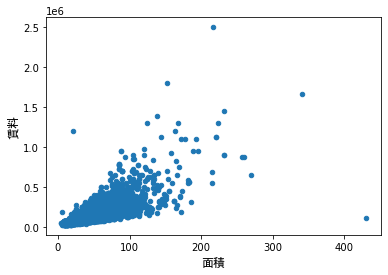

In [12]:
data.plot.scatter(x='面積', y='賃料')
plt.xlabel('面積', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.savefig('scatter_01.png')
plt.show()

ただ、この散布図を確認すると以下の様な3個ほどの外れ値らしき点が存在します。<br>
これら外れ値の賃料が本当に正しいデータであるかを、他のデータと比較しながら見ていきます。<br>

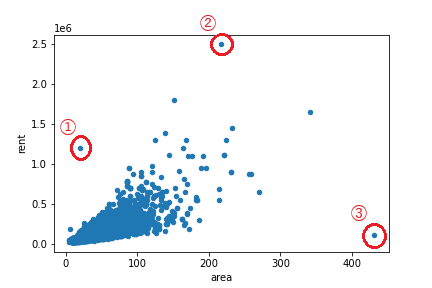

In [13]:
# 3点の外れ値
im = Image.open('scatter_01_copy.png')
im

・点①について<br>
点①のデータを抜き出すために、該当しそうな条件で検索すると、以下のデータを見つけ出すことができました。<br>

In [14]:
# 特定の条件で検索
data['賃料'][(data['面積'] < 50) & (data['賃料'] > 1000000)]

5775    1203500
Name: 賃料, dtype: int64

In [15]:
# 点①のデータ
data[data.index == 5775]

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区
5775,5776,1203500,東京都港区新橋４丁目,山手線\t新橋駅\t徒歩2分\t\t都営大江戸線\t汐留駅\t徒歩2分,1K,12,北西,20.53,10階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,...,インターネット対応／\t光ファイバー／\tCATV／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 570m\t【コンビニ】 43m\t【コンビニ】 2...,RC（鉄筋コンクリート）,2年間,10.0,15.0,2,港


この物件と似たような物件の賃料も確認してみましょう。<br>

In [16]:
# 港区,間取りが1K,築年数が12年,階数が10階の物件を表示
similar_data_1 = data[(data['区'] == '港') & (data['間取り'] == '1K') 
                    & (data['築年数'] == 12) & (data['階数'] == 10)]
similar_data_1

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区
5775,5776,1203500,東京都港区新橋４丁目,山手線\t新橋駅\t徒歩2分\t\t都営大江戸線\t汐留駅\t徒歩2分,1K,12,北西,20.53,10階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,...,インターネット対応／\t光ファイバー／\tCATV／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 570m\t【コンビニ】 43m\t【コンビニ】 2...,RC（鉄筋コンクリート）,2年間,10.0,15.0,2,港
7174,7175,128000,東京都港区新橋４丁目,東海道本線\t新橋駅\t徒歩2分\t\t都営大江戸線\t汐留駅\t徒歩7分\t\t都営三田線...,1K,12,南東,20.53,10階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,...,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ／\t...,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t54,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 434m\t【コンビニ】 971m,RC（鉄筋コンクリート）,2年間,10.0,15.0,2,港
12748,12749,129500,東京都港区新橋４丁目,山手線\t新橋駅\t徒歩2分\t\t都営大江戸線\t汐留駅\t徒歩2分,1K,12,北西,20.49,10階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,...,インターネット対応／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 570m\t【コンビニ】 43m\t【コンビニ】 2...,RC（鉄筋コンクリート）,2年間,10.0,15.0,2,港
26732,26733,139500,東京都港区新橋６丁目,都営三田線\t御成門駅\t徒歩3分\t\t東海道本線\t新橋駅\t徒歩10分\t\t都営浅草...,1K,12,東,20.30,10階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー,...,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ／\t...,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 350m\t【スーパー】 2931m\t【コンビニ】 140m\t【コンビニ】...,SRC（鉄骨鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,10.0,15.0,3,港


これら物件の賃料を見てみると10万～20万であることが分かります。<br>
このことから、この物件は賃料の桁数の間違えによる入力ミスである可能性が高そうです。なので、賃料を1203500から120350に変更しましょう。<br>

In [17]:
# 賃料の変更
data['賃料'][data.index == 5775] = 120350
# 変更後確認
data['賃料'][data.index == 5775]

5775    120350
Name: 賃料, dtype: int64

・点②について<br>
点②のデータも同様に検索します。<br>

In [18]:
# 特定の条件で検索
data['賃料'][(data['面積'] < 400) & (data['賃料'] > 2000000)] 

5093    2500000
Name: 賃料, dtype: int64

In [19]:
# 点②のデータ
data[data.index == 5093]

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区
5093,5094,2500000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1,西,217.29,9階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,...,インターネット対応,エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【スーパー】 65...,RC（鉄筋コンクリート）,3年間\t※この物件は\t定期借家\tです。,9.0,11.0,8,港


この物件と似たような物件を探してみましょう。<br>

In [20]:
# 港区,間取りが2LDK+S(納戸),築年数が1年の物件を表示
similar_data_2 = data[(data['区'] == '港') & (data['間取り'] == '2LDK+S(納戸)') 
                    & (data['築年数'] == 1)]
similar_data_2

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区
5093,5094,2500000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1,西,217.29,9階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,...,インターネット対応,エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【スーパー】 65...,RC（鉄筋コンクリート）,3年間\t※この物件は\t定期借家\tです。,9.0,11.0,8,港
20643,20644,1800000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1,南,151.81,5階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,...,インターネット対応,エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【スーパー】 65...,RC（鉄筋コンクリート）,3年間\t※この物件は\t定期借家\tです。,5.0,11.0,8,港


これら物件の賃料を比較して見てみると、大きな差はないように見えます。<br>
この物件の賃料は桁数の入力ミスである可能性は低そうです。なので、外れ値としての処理は保留にしておきます。<br>

・点③について<br>
同様に検索し、似た物件の賃料と比較してみましょう。<br>

In [21]:
# 特定の条件で検索
data['賃料'][(data['面積'] > 400) & (data['賃料'] < 250000)]

20926    116000
Name: 賃料, dtype: int64

In [22]:
# 点③のデータ
data[data.index == 20926]

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区
20926,20927,116000,東京都荒川区南千住７丁目,日比谷線\t南千住駅\t徒歩7分\t\t京成本線\t千住大橋駅\t徒歩10分\t\t都電荒川...,2LDK,19,西,430.1,2階／10階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立...,...,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 532m\t【コンビニ】 111m\t【コンビニ】 ...,鉄骨造,NaN,2.0,10.0,7,荒川


In [23]:
# 荒川区,間取りが2LDK,築年数が15-20年,階数が2階の物件を表示
similar_data_3 = data[(data['区'] == '荒川') & (data['間取り'] == '2LDK') 
                    & (data['築年数'] >= 15) & (data['築年数'] <= 20)
                    & (data['階数'] == 2)]
similar_data_3

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区
13313,13314,140000,東京都荒川区西尾久７丁目,高崎線\t尾久駅\t徒歩5分\t\t山手線\t田端駅\t徒歩22分\t\t都電荒川線\t荒川...,2LDK,18,南東,56.81,2階／7階建,専用トイレ／\tバス・トイレ別／\t洗面台独立,...,NaN,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\tエ...,"駐車場\t空有(1台)\t25,920円",【スーパー】 52m\t【コンビニ】 5m\t【ドラッグストア】 254m\t【図書館】 3...,RC（鉄筋コンクリート）,2年間,2.0,7.0,4,荒川
17113,17114,116000,東京都荒川区南千住７丁目１２－６,日比谷線\t南千住駅\t徒歩6分\t\t京成本線\t千住大橋駅\t徒歩10分\t\t都電荒川...,2LDK,19,西,43.01,2階／10階建,専用バス／\tバス・トイレ別／\tシャワー／\t洗面台独立,...,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\tエ...,"駐車場\t空有\t27,000円\t距離0m",NaN,鉄骨造,2年間,2.0,10.0,6,荒川
18016,18017,140000,東京都荒川区西尾久７丁目,山手線\t田端駅\t徒歩16分\t\t高崎線\t尾久駅\t徒歩4分\t\t京浜東北線\t上中...,2LDK,18,南東,56.81,2階／7階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,...,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐車場\t空有\t25,920円\t距離0m\t駐輪場\t空有\tバイク置き場\t空有\t1...",【幼稚園・保育園】 1888m\t【幼稚園・保育園】 1768m\t【小学校】 1834m\...,RC（鉄筋コンクリート）,2年間,2.0,7.0,4,荒川
20926,20927,116000,東京都荒川区南千住７丁目,日比谷線\t南千住駅\t徒歩7分\t\t京成本線\t千住大橋駅\t徒歩10分\t\t都電荒川...,2LDK,19,西,430.10,2階／10階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立...,...,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 432m\t【スーパー】 532m\t【コンビニ】 111m\t【コンビニ】 ...,鉄骨造,NaN,2.0,10.0,7,荒川


これら物件の間取りと面積を確認すると、2LDKの広さは平均46～50㎡であるにも関わらず、点③の物件の面積が異常に高い数値になっています。<br>
この物件は面積の桁数の間違えによる入力ミスである可能性が高そうです。なので、面積を430.10から43.10に変更しましょう。<br>

In [24]:
# 面積の変更
data['面積'][data.index == 20926] = 43.10
# 変更後確認
data['面積'][data.index == 20926]

20926    43.1
Name: 面積, dtype: float64

以上の変更により外れ値を修正できました。

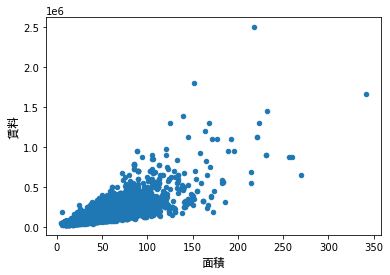

In [25]:
# 面積と賃料の散布図
data.plot.scatter(x='面積', y='賃料')
plt.xlabel('面積', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

2つの変数の相関関係を数値として確認することも重要です。<br>
面積と賃料の相関係数を確認すると、約0.75と高い相関係数になっています。<br>

In [26]:
# 相関係数を算出
data.corr()

,id,賃料,築年数,面積,階数,最上階,所要時間
id,1.000000,0.000514,-0.000711,-0.002679,0.006509,0.002155,-0.005556
賃料,0.000514,1.000000,-0.229694,0.758213,0.457567,0.465548,-0.123756
築年数,-0.000711,-0.229694,1.000000,-0.023593,-0.147500,-0.193343,0.071253
面積,-0.002679,0.758213,-0.023593,1.000000,0.290898,0.252086,0.062448
階数,0.006509,0.457567,-0.147500,0.290898,1.000000,0.773537,-0.188811
最上階,0.002155,0.465548,-0.193343,0.252086,0.773537,1.000000,-0.221633
所要時間,-0.005556,-0.123756,0.071253,0.062448,-0.188811,-0.221633,1.000000


次に「仮説２：部屋の階数が高い方が、また高層マンションの方が賃料は高いのではないか」を検証するため、<br>
階数と賃料の散布図、最上階と賃料の散布図を描くと、階数・最上階と賃料には相関が見られます。<br>
また、階数が高くなるにつれて賃料の最小値が高くなっている事や、階数が低くても賃料が高い物件がある事も分かります。<br>

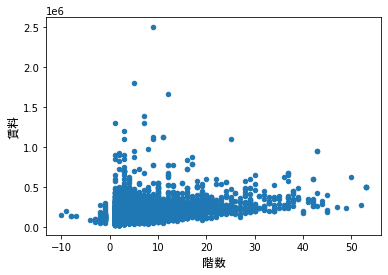

In [27]:
# 階数と賃料の散布図
data.plot.scatter(x='階数', y='賃料')
plt.xlabel('階数', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

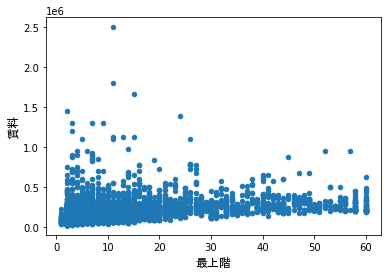

In [28]:
# 最上階と賃料の散布図
data.plot.scatter(x='最上階', y='賃料')
plt.xlabel('最上階', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

同じ3階でも、3階建ての3階と30階建ての3階では価値が異なります。<br>
そこで、絶対的な階数のみではなく、階数を最上階で割った相対的な階数を表す「階数率」カラムを作成しましょう。<br>

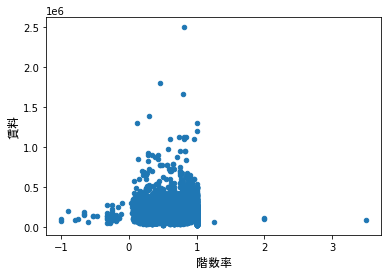

In [29]:
# 階数率カラムの作成
data['階数率'] = data['階数'] / data['最上階']

# 階数率と賃料の散布図
data.plot.scatter(x='階数率', y='賃料')
plt.xlabel('階数率', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

上の散布図を確認すると、階数率が1を超えたデータがいくつか存在します。<br>
最上階を超える階数は存在しないので、階数率は1以下の値になるはずです。<br>
それらのデータを以下で検索すると、階数と最上階を間違えて入力してしまった可能性があることが読み取れます。<br>

In [30]:
# 階数率が1を超えた物件を検索
data[data['階数率'] > 1]

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区,階数率
1203,1204,110000,東京都文京区小日向１丁目22-2,丸ノ内線(池袋－荻窪)\t茗荷谷駅\t徒歩6分\t\t有楽町線\t江戸川橋駅\t徒歩9分\t...,1R,2,NaN,26.03,2階／1階建,バス・トイレ別／\tシャワー,...,エアコン付\tフローリング,駐輪場\t空有\t0円,NaN,木造,2年間,2.0,1.0,6,文京,2.00
14238,14239,62000,東京都港区海岸３丁目2-9,山手線\t田町(東京都)駅\t徒歩10分\t\t都営三田線\t三田(東京都)駅\t徒歩15分...,1R,44,南東,13.77,10階／8階建,専用バス／\t専用トイレ／\tシャワー,...,エアコン付\tフローリング／\t敷地内ごみ置き場\t／\tエレベーター\t公営水道／\t下水,駐輪場\t無\tバイク置き場\t無,【ドラッグストア】 532m\t【飲食店】 242m\t【飲食店】 304m\t【スーパー】...,SRC（鉄骨鉄筋コンクリート）,2年間,10.0,8.0,6,港,1.25
20743,20744,89000,東京都杉並区高円寺南４丁目,総武線・中央線（各停）\t高円寺駅\t徒歩3分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,1K,17,南東,19.13,7階／2階建,バス・トイレ別／\tシャワー／\t浴室乾燥機,...,エアコン付\tシューズボックス／\t出窓／\tバルコニー／\tフローリング／\t2面採光／\...,"駐輪場\t空有\t1,000円\t駐車場\t無",【スーパー】 280m\t【コンビニ】 277m\t【ドラッグストア】 5142m\t【病院...,RC（鉄筋コンクリート）,2年間,7.0,2.0,3,杉並,3.50
21504,21505,103000,東京都練馬区春日町１丁目9-8,都営大江戸線\t練馬春日町駅\t徒歩8分\t\t西武豊島線\t豊島園(西武線)駅\t徒歩13...,2LDK,32,南,43.32,4階／2階建,専用バス／\t専用トイレ／\tシャワー／\t洗面台独立／\t脱衣所,...,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\tエ...,"駐輪場\t空有\t駐車場\t近隣\t25,000円(税込)\t距離250m\tバイク置き場\t無",【スーパー】 245m\t【スーパー】 476m\t【スーパー】 793m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,4.0,2.0,8,練馬,2.00


これらの階数と最上階の値を入れ替えましょう。<br>

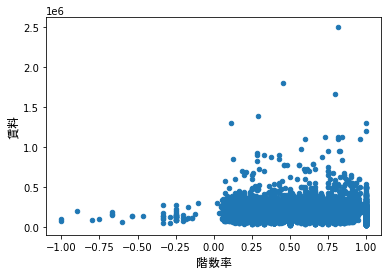

In [31]:
# 階数率が1より大きい物件の階数と最上階の値を入れ替え、再度「階数率」カラムを作成
data['階数'][data['id']==1204] = 1
data['最上階'][data['id']==1204] = 2

data['階数'][data['id']==14239] = 8
data['最上階'][data['id']==14239] = 10

data['階数'][data['id']==20744] = 2
data['最上階'][data['id']==20744] = 7

data['階数'][data['id']==21505] = 2
data['最上階'][data['id']==21505] = 4

data['階数率'] = data['階数'] / data['最上階']

# 修正後の階数率を確認
data.plot.scatter(x='階数率', y='賃料')
plt.xlabel('階数率', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

階数率と賃料に相関は見られませんでした。<br>

次に「仮説３：築年数が古いほど賃料は安くなるのではないか」「仮説４：最寄駅までの距離が遠いと賃料は安くなるのではないか」<br>
を検証していきます。築年数・所要時間と賃料の散布図を描いてみましょう。<br>

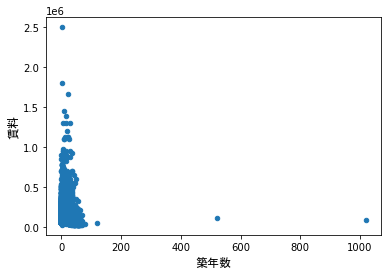

In [32]:
# 築年数と賃料の散布図
data.plot.scatter(x='築年数', y='賃料')
plt.xlabel('築年数', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

このとき、築年数が異常に高いデータ（外れ値）が存在することが分かります。以下の3件になります。<br>

In [33]:
# 築年数が100年を超える物件を検索
data[data['築年数'] > 100]

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区,階数率
20231,20232,112000,東京都板橋区蓮根３丁目,都営三田線\t西台駅\t徒歩7分\t\t都営三田線\t蓮根駅\t徒歩7分,2DK+S(納戸),520,南,51.30,3階／3階建,専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,...,エアコン付\t出窓／\tバルコニー／\tフローリング／\t室内洗濯機置場／\tタイル張り,NaN,NaN,鉄骨造,NaN,3.0,3.0,7,板橋,1.0
20427,20428,82000,東京都目黒区中町２丁目,東急東横線\t祐天寺駅\t徒歩11分\t\t東急東横線\t中目黒駅\t徒歩15分\t\t東急...,1DK,1019,南,24.00,2階／2階建,専用トイレ／\tバス・トイレ別／\tシャワー,...,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室外洗濯機置場／\tタ...,NaN,NaN,鉄骨造,NaN,2.0,2.0,11,目黒,1.0
22247,22248,52000,東京都世田谷区砧７丁目,小田急小田原線\t祖師ケ谷大蔵駅\t徒歩10分\t\t小田急小田原線\t成城学園前駅\t徒歩15分,1K,119,NaN,18.15,1階／2階建,専用トイレ,...,エアコン付\t公営水道,NaN,NaN,木造,NaN,1.0,2.0,10,世田谷,0.5


木造あるいは鉄骨造の建築物に対して、百年以上または千年以上の築年数になっていますので、これらは間違ったデータだと読み取れます。<br>
これらのデータについては、正しい築年数が不明であり修正することができないので削除します。<br>

In [34]:
# 以上3件のデータを削除
data = data.drop(index=[20231, 20427, 22247], axis=0)
# 削除されているか確認
data[data['築年数'] > 100]

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,...,室内設備,駐車場,周辺環境,建物構造,契約期間,階数,最上階,所要時間,区,階数率


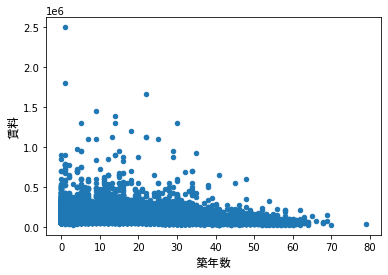

In [35]:
# 修正後の散布図
data.plot.scatter(x='築年数', y='賃料')
plt.xlabel('築年数', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

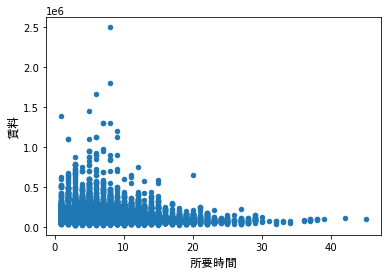

In [36]:
# 所要時間と賃料の散布図
data.plot.scatter(x='所要時間', y='賃料')
plt.xlabel('所要時間', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

はっきりとした相関は見られませんが、古い物件や所要時間が長い物件は賃料が安い傾向がある事が分かるので、築年数と所要時間は特徴量として有効そうです。  <br>

「仮説５：建物構造によって賃料は違うのではないか」を検証するため、建物構造と賃料の箱ひげ図を描いてみましょう。<br>
箱ひげ図の結果から、木造は安く鉄筋コンクリートは高い等、仮説通り建物構造によって賃料が異なることが分かります。<br>

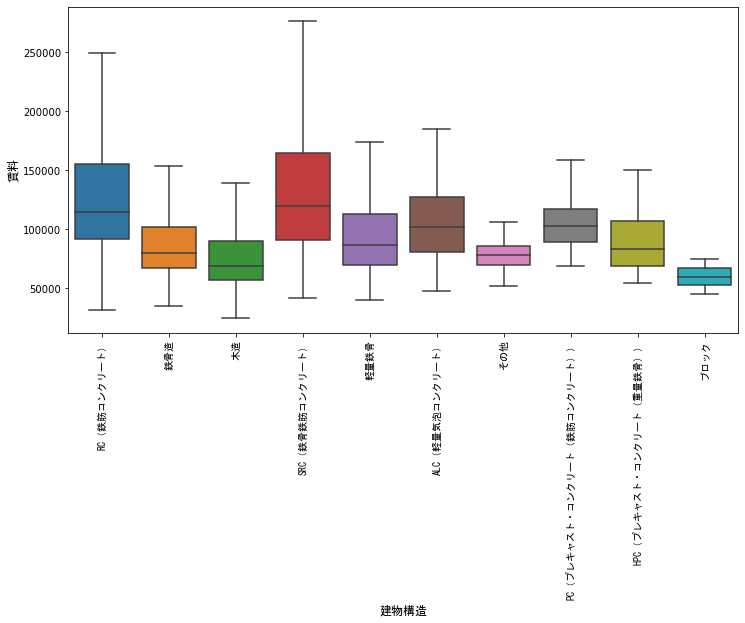

In [37]:
# 建物構造をx軸、賃料をy軸にした箱ひげ図(外れ値を除外)
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='建物構造', y='賃料', sym='')
plt.xticks(rotation=90, fontname='MS Gothic') # x軸のラベルを見やすいように回転
plt.xlabel('建物構造', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

「仮説６：区によって賃料の相場は違うのではないか」の検証についても、上と同様に箱ひげ図を描いてみます。<br>
箱ひげ図の結果から、仮説通り区によって賃料の分布が異なることが分かるので、区の情報も予測に使うことができそうです。<br>

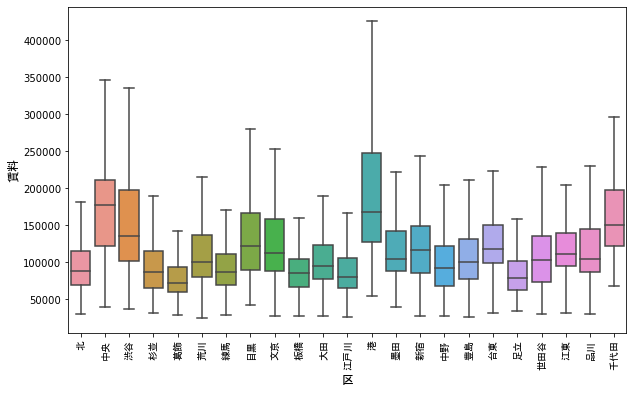

In [38]:
# 区をx軸、賃料をy軸にした箱ひげ図(外れ値を除外)
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x='区', y='賃料', sym='')
plt.xticks(rotation=90, fontname='MS Gothic') # x軸のラベル名を回転
plt.xlabel('区', fontproperties=fp)
plt.ylabel('賃料', fontproperties=fp)
plt.show()

これまでの検証により以下のことが分かりました。<br>
<br>
・面積が広い方が家賃は高くなる傾向がある。<br>
・部屋と最上階の階数が高いほど、家賃も高くなる傾向がある。<br>
・築年数が古いほど家賃は安くなる傾向がある。<br>
・最寄駅までの距離が遠いと家賃は安くなる傾向がある。<br>
・建物構造によって家賃分布は異なる。<br>
・区によって家賃分布は異なる。<br>
<br>
従って、カラム｛面積、部屋、最上階、階数率、築年数、所要時間、建物構造、区｝を予測に使用していきます。<br>

### 

## ３．賃料予測モデルの作成

賃料の予測モデルを作成する前に、学習データ全体に欠損値が無いかを確認します。<br>

In [39]:
# 予測に使用する特徴量
select_columns = ['面積','階数','最上階','階数率','築年数','所要時間','建物構造','区']
# 欠損値を確認
print(data[select_columns].isnull().sum())

面積        0
階数      714
最上階       0
階数率     714
築年数       0
所要時間      0
建物構造      0
区         0
dtype: int64


欠損値を含んだままだとモデルの作成ができないので、今回は欠損値を-99で埋めます。<br>
-99という値自体には意味はなく、データに含まれない値で欠損であることを表現できれば他の値でも構いません。<br>

In [40]:
# 学習データで階数、階数率の欠損値を-99で埋める
data[select_columns] = data[select_columns].fillna(-99)

モデル作成に使用するデータは全て数値である必要があります。<br>
「建物構造」と「区」は質的データなので、モデルで扱えるようにするために『ダミー変数化』を行い量的データに変換します。<br>
ダミー変数化とは、質的データを量的データに置き換える方法です。質的データをコンピュータに理解させるためには、値を1と0に置き換える必要があります。<br>
置き換えは、質的データ内の各要素を表すカラムを新たに作成し、その要素に対応する行には1を、それ以外は全て0を入れることで実現します。<br>

In [41]:
# 学習データで今回使用する特徴量をダミー化
X_data = pd.get_dummies(data[select_columns])
# 学習データの目的変数
y_data = data['賃料']

また、学習データにない建物構造の値がテストデータには1つ存在するので、ダミー変数化後のカラムとして学習データに追加しておきます。<br>
（ダミー変数化は質的データの値を全てカラムとして新たに追加する処理なので、ダミー変数化後のテストデータのカラム数が学習データより1つ多くなる）<br>

In [42]:
# テストデータに有るデータをカラムとして追加
X_data.insert(X_data.columns.get_loc('建物構造_鉄骨造'), '建物構造_鉄筋ブロック', 0)

今回の分析では、『ランダムフォレスト』という機械学習モデルを使用します。<br>
ランダムフォレストの前に、まず『決定木モデル』について解説します。<br>
<br>
決定木モデルとは、ある質問に対する2択の分岐を階層的に作ることで、分類または回帰を行う手法です。<br>
例えば、目的変数が「テニスをするorしない」、説明変数が「天気、気温、風の強さ」だとすると、<br>
以下の図の様に最初に天気の質問をして、雨の場合は「しない」と判定、晴れの場合はさらに気温についての質問、<br>
曇りの場合はさらに風の強さについて質問、と階層的に分けていき最終的に「テニスをするorしない」どちらかを判定するノードに属するように構築していきます。<br>
決定木モデルの作成・学習とは、この「質問の階層」を構築することを意味します。<br>
<br>
このモデルには以下の特徴があります：<br>
・予測が非常に高速<br>
・データの違い(例えば、身長cmと体重kg、年齢(数値)と性別(文字列))を考慮しなくて良い<br>
・基本的に2択の分岐を繰り返す構造なので、モデルの可視化が可能<br>

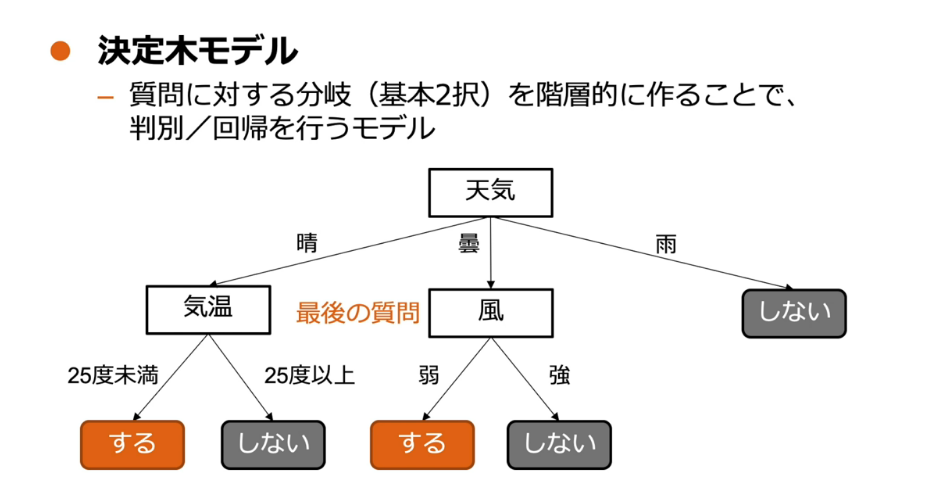

In [43]:
# 決定木のイメージ図
im = Image.open('decision_tree_sample.png')
im

そしてランダムフォレストとは、簡単に言うと「複数の決定木を使用したモデル」です。<br>
全ての決定木に同じデータを使うと同じ出力結果になってしまうので、<br>
各決定木に異なる構造（ランダム性）を持たせるために、異なるデータや特徴量を使用させます。<br>
回帰問題の場合は各決定木の出力結果の平均値を出力し、分類問題の場合は多数決で出力します。<br>

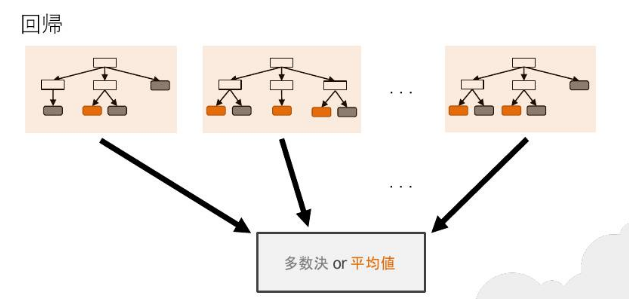

In [44]:
# ランダムフォレストのイメージ図
im = Image.open('random_forest_regressor.png')
im

以下、既存の学習データをさらに学習データと評価データに8:2の割合で分割します。<br>
その後、回帰用のランダムフォレストのモデルを学習させます。<br>

In [45]:
# 学習データと評価データへ分割
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2)
# 回帰用ランダムフォレストを準備
model = RandomForestRegressor(random_state=42)
# 学習データを用いてモデルの学習
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:
estimator = model.estimators_[5]

学習済みモデルを用いて検証データから予測値を算出し、モデルの精度を確認することも大切です。<br>
今回の予測モデルでは大きな予測誤差を出さないモデルを作成する目的に合わせて、評価関数「RMSE」を使用します。(詳細は省略)<br>
RMSEの特徴は、複数の予測対象のうち1つでも大きく予測を外すと評価の値が大きく悪化することです。予測を大きく外すことが弊害となる課題で使用されます。<br>

In [47]:
# 評価データに対する予測
pred = model.predict(X_valid)
# 予測精度を確認
print('RMSE：', np.sqrt(MSE(y_valid, pred)))

RMSE： 20545.1925218274


また、実測値と予測値を用いて以下の様な散布図を作成することもできます。<br>
多くのデータ点が対角線上に近づくほど、正しく予測ができている事を意味します。<br>

Text(0, 0.5, '予測値')

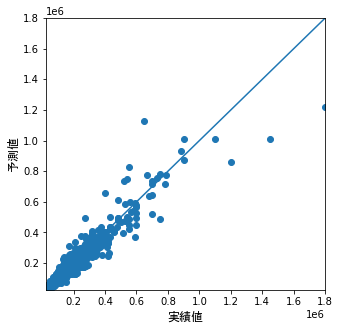

In [48]:
# 1.グラフのサイズを指定し、グラフの大きさを正方形になるように設定
plt.figure(figsize=(5,5))

# 2.横軸を実測値、縦軸を予測値として、散布図を描く
plt.scatter(y_valid, pred)

# y_valid及びy_pred_validの最小値・最大値
valid_min = np.min(y_valid)
valid_max = np.max(y_valid)
pred_min = np.min(pred)
pred_max = np.max(pred)

# 3.値域を揃える為に、y_test、predの両方を見た上での最小値と最大値を求める
min_value = np.minimum(valid_min, pred_min)
max_value = np.maximum(valid_max, pred_max)

# 4.最小値と最大値を使い、x軸およびy軸の値域を指定
plt.xlim([min_value,max_value])
plt.ylim([min_value,max_value])

# 5.対角線を描く
plt.plot([min_value, max_value],[min_value, max_value])

#x軸とy軸に名前を付ける
plt.xlabel('実績値', fontproperties = fp)
plt.ylabel('予測値', fontproperties = fp)

### 

## ４．テストデータによる予測

作成したモデルを用いて、データtest.csvに対して賃料を予測します。<br>

In [49]:
# テストデータの読み込み
test = pd.read_csv('./signate_data/rental/test.csv')
# テストデータの一部を表示
test.head(20)

,id,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,31471,東京都世田谷区深沢５丁目1-27,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,2LDK,49年0ヶ月,南,50.22m2,8階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...,鉄骨造,NaN
1,31472,東京都目黒区八雲１丁目11-8,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,1R,0年2ヶ月,南東,20.88m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...,"駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
2,31473,東京都豊島区池袋本町２丁目22-2,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,1K,23年4ヶ月,南東,26.93m2,1階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...,"駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...",【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...,鉄骨造,2年間
3,31474,東京都杉並区和泉１丁目,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩10分\t\t京王線\t代田橋駅\t徒歩8分...,1K,36年2ヶ月,南東,23.57m2,1階／2階建,シャワー,ガスコンロ／\t給湯,NaN,エアコン付\tシューズボックス／\t2面採光／\t室外洗濯機置場\t公営水道／\t下水／\t...,駐輪場\t空有\t0円,【スーパー】 286m\t【スーパー】 702m\t【コンビニ】 489m\t【コンビニ】 ...,木造,2年間
4,31475,東京都杉並区堀ノ内２丁目,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩12分\t\t丸ノ内線(池袋－荻窪)\t新高...,2LDK,45年4ヶ月,南,50m2,4階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別,コンロ設置可（口数不明）／\t給湯,インターネット対応,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置...,"駐車場\t近隣\t22,600円\t距離177m",【コンビニ】 312m\t【コンビニ】 436m\t【スーパー】 902m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
5,31476,東京都新宿区西新宿５丁目10-3,都営大江戸線\t西新宿五丁目駅\t徒歩4分\t\t都営大江戸線\t都庁前駅\t徒歩8分\t\...,1R,25年6ヶ月,西,21.45m2,1階／2階建,専用バス／\t専用トイレ／\tシャワー,ガスコンロ／\tコンロ1口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tロフト付き／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 188m\t【スーパー】 642m\t【スーパー】 798m\t【コンビニ】 ...,木造,2年間
6,31477,東京都港区芝１丁目,山手線\t浜松町駅\t徒歩10分\t\t山手線\t田町(東京都)駅\t徒歩10分\t\t都営...,1K,17年8ヶ月,NaN,19.98m2,3階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\tコンロ1口／\t給湯,インターネット対応／\t光ファイバー／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,"駐輪場\t空有\t駐車場\t近隣\t40,000円(税込)\t距離400m\tバイク置き場\t無",【スーパー】 156m\t【スーパー】 405m\t【スーパー】 338m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
7,31478,東京都渋谷区本町５丁目,京王新線\t幡ケ谷駅\t徒歩11分\t\t都営大江戸線\t西新宿五丁目駅\t徒歩13分\t\...,1R,4年0ヶ月,北,24.44m2,3階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t2面採光／\t3面採光／\t室内洗濯機...,NaN,【飲食店】 553m\t【スーパー】 377m\t【コンビニ】 192m\t【コンビニ】 6...,木造,2年間
8,31479,東京都葛飾区西新小岩３丁目,総武線・中央線（各停）\t新小岩駅\t徒歩18分\t\t総武線・中央線（各停）\t平井(東京...,1R,13年1ヶ月,南,36.32m2,2階／2階建,バス・トイレ別／\tシャワー／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\tカウンターキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,"駐輪場\t空有\t駐車場\t近隣\t19,000円\t距離130m\tバイク置き場\t無",【スーパー】 822m\t【スーパー】 561m\t【コンビニ】 190m\t【スーパー】 ...,木造,2年間
9,31480,東京都杉並区梅里２丁目,丸ノ内線(池袋－荻窪)\t新高円寺駅\t徒歩2分\t\t中央線（快速）\t高円寺駅\t徒歩1...,1DK,13年6ヶ月,東,32.64m2,5階／7階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,光ファイバー／\tBSアンテナ,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,"駐輪場\t空有\t540円\tバイク置き場\t空有\t6,480円",【飲食店】 72m\t【飲食店】 99m\t【ドラッグストア】 213m\t【スーパー】 1...,RC（鉄筋コンクリート）,2年間


In [50]:
# テストデータの情報を確認
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31262 entries, 0 to 31261
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31262 non-null  int64 
 1   所在地     31262 non-null  object
 2   アクセス    31262 non-null  object
 3   間取り     31262 non-null  object
 4   築年数     31262 non-null  object
 5   方角      28454 non-null  object
 6   面積      31262 non-null  object
 7   所在階     31261 non-null  object
 8   バス・トイレ  30942 non-null  object
 9   キッチン    30627 non-null  object
 10  放送・通信   27808 non-null  object
 11  室内設備    31189 non-null  object
 12  駐車場     25906 non-null  object
 13  周辺環境    22021 non-null  object
 14  建物構造    31262 non-null  object
 15  契約期間    24281 non-null  object
dtypes: int64(1), object(15)
memory usage: 3.8+ MB


モデルに入力するための前処理を、テストデータに対しても同様に行います。<br>

In [51]:
# テストデータに対する特徴量加工
test['面積'] = test['面積'].apply(lambda x : change_area(x))
test['築年数'] = test['築年数'].apply(lambda x: change_age(x))
test['階数'] = test["所在階"].apply(get_floor)
test['最上階'] = test['所在階'].apply(get_top_floor)
test['所要時間'] = test['アクセス'].apply(get_min_time)
test['区'] = test['所在地'].apply(lambda x : x[x.find('都')+1 : x.find('区')])
test['階数率'] = test['階数'] / test['最上階']

In [52]:
# テストデータで、階数・階数率の欠損値を-99で埋める
test[select_columns] = test[select_columns].fillna(-99)

In [53]:
# テストデータで今回使用する特徴量をダミー化
X_test = pd.get_dummies(test[select_columns])

これでテストデータを予測モデルに入力し、予測を行うことができるようになりました。<br>

In [54]:
# 予測値の算出
y_pred_test = model.predict(X_test)

In [55]:
# 予測結果をDataFrame型でまとめ、提出用のCSVファイルを作成
result = pd.DataFrame({'id': test['id'], 'y': y_pred_test})
result.to_csv('./signate_result/rental_competition_predicted.csv', header=False, index=False)
result

,id,y
0,31471,125130.000000
1,31472,117720.000000
2,31473,75430.000000
3,31474,58930.000000
4,31475,114015.000000
...,...,...
31257,62728,101011.833333
31258,62729,102656.000000
31259,62730,174120.000000
31260,62731,258685.000000


出力したCSVファイルをコンペティションにて投稿して完了です。

最終投稿日時：2021-07-02 16:57:13 <br>
最終評価：20,574.2713787 <br>
最終順位：230位 / 561人投稿 <br>